# Interpolatiing Barium on a sphere

* A notebook of my work on interpolation from field obs. to grided data for the model run.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Content
1. [**Barium Samples**](#Barium-Samples)
  2. [GIPY 2007-11](#GIPY-2007-11)
  2. [BGEP 2003-2005](#BGEP-2003-2005)
  2. [CLIVAR Carbon and Hydrographic Data center](#CLIVAR-Carbon-and-Hydrographic-Data-center)
1. [**Interpolation**](#Interpolation)
  2. [Reconstruct vertical profiles](#Reconstruct-vertical-profiles)
    3. ["Correction of bounds"](#"Correction-of-bounds")
    3. [Above 500m](#Above 500m)
    3. [Deep ocean](#Deep ocean)
    3. [Combined](#Combined)
  2. [Horizontal frame](#Horizontal-frame)
    3. [Projection transformation](#Projection-transformation)
    3. [Interpolating each layer](#Interpolating-each-layer)
    3. [A comparison: directly interpolating each layers](#A-comparison:-directly-interpolating-each-layers)
1. [**Remap on ORCA2 frame**](#Remap-on-ORCA2-frame)
  2. [Plot](#Plot)

In [2]:
import sys
sys.path.insert(0, '_libs/')

In [3]:
import glob
#import pyproj
import scipy.io
import numpy as np
import netCDF4 as nc
from NEMO_tools import int_profile, bin_profile
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [4]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

In [5]:
def check_bounds(out, bounds_low, bounds_up):
    '''
    "What out of bounds becomes nan"
    '''
    out_adj = np.copy(out)
    for i in range(133):
        for j in range(17):
            if((out[i, j]<bounds_low[j]) | (out[i, j]>bounds_up[j])):
                out_adj[i, j]=np.nan
    return out_adj

In [6]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran
SB=[0.06, 0.05, 0.03]    # Smokey Black
AFB = [0.36, 0.54, 0.66] # Air Force Blue
AG = [0.55, 0.71, 0.0]   # Apple Green
AZ = [0.0, 0.5, 1.0]     # Azure
CB = [0.37, 0.62, 0.63]  # Cadet blue
SP = [1.0, 0.72, 0.77]   # Sakura
CamB = [0.64, 0.76, 0.68]# Cambridge blue
DC = [0.0, 0.55, 0.55]   # Dark cyan
DE = [0.08, 0.38, 0.74]  # Denim
BB = [0.54, 0.81, 0.94]  # Baby blue

# Barium Samples

Only the sample labeled as **good** will be perserved ("moderate", "questionable", "unkonwn" etc. will not)

## GIPY 2007-11

* Data is collected from Jul 2007 to Sep 2007
* Only the "good" data points selected
* CTD depth above 15m as "surface"

In [7]:
MAT = scipy.io.loadmat('_data/Samples/GIPY11/GIPY11_Ba.mat')
GIPY_lons = MAT['Ba_records'][:, 0]
GIPY_lats = MAT['Ba_records'][:, 1]
GIPY_deps = MAT['Ba_records'][:, 2]
GIPY_Ba   = MAT['Ba_records'][:, 3]
#
GIPY_lons[GIPY_lons>180]=GIPY_lons[GIPY_lons>180]-360

## BGEP 2003-2005

* http://www.whoi.edu/page.do?pid=66521
* Data collected at the summer of 2003, 2004, 2005
* Only "Good" data points selected
* CTD depth above 15m as "surface"

In [8]:
MAT = scipy.io.loadmat('_data/Samples/BGEP/BGEP_Ba.mat')
x03 = MAT['Ba2003'][:, 1]; y03 = MAT['Ba2003'][:, 0]; z03 = MAT['Ba2003'][:, 2]; Ba03 = MAT['Ba2003'][:, 3]
x04 = MAT['Ba2004'][:, 1]; y04 = MAT['Ba2004'][:, 0]; z04 = MAT['Ba2004'][:, 2]; Ba04 = MAT['Ba2004'][:, 3]
x04[Ba04<0]=np.nan; y04[Ba04<0]=np.nan; z04[Ba04<0]=np.nan; Ba04[Ba04<0]=np.nan
x05 = MAT['Ba2005'][:, 1]; y05 = MAT['Ba2005'][:, 0]; z05 = MAT['Ba2005'][:, 2]; Ba05 = MAT['Ba2005'][:, 3]

## CLIVAR Carbon and Hydrographic Data center

http://www.clivar.org/resources/data/hydrographic

* HLY0301-32H120030721, Kelley Falkner http://seahunt.ucsd.edu/cruise/32H120030721
* CBL-32PZ20020819,  Rebecca Woodgate http://seahunt.ucsd.edu/cruise/32PZ20020819
* ARK-IX_4_1993-06AQ19930806, D.K. Fütterer http://seahunt.ucsd.edu/cruise/06AQ19930806

#Interpolation

## Reconstruct vertical profiles

In [9]:
nc_name=glob.glob('_data/NEMO/ORCA2_LIM_PISCES/ORCA2_5d_19700101_19701231_ptrc_T*')
nc_obj=nc.Dataset(nc_name[0])
deptht = nc_obj.variables['deptht'][:]

In [10]:
x_all = np.hstack((GIPY_lons, x03, x04, x05))
y_all = np.hstack((GIPY_lats, y03, y04, y05))
z_all = np.hstack((GIPY_deps, z03, z04, z05))
Ba_all = np.hstack((GIPY_Ba, Ba03, Ba04, Ba05))

In [11]:
GIPY_locs = np.unique(GIPY_lons)
loc03 = np.unique(x03)
loc04 = np.unique(x04)
loc05 = np.unique(x05)

### "Correction of bounds"

In [12]:
x_surf = x_all[z_all<250]; y_surf = y_all[z_all<250]; z_surf = z_all[z_all<250]
Ba_surf = Ba_all[z_all<250]; dep_surf = deptht[deptht<250]

In [13]:
locx, locy, out_surf = int_profile(x_surf, y_surf, z_surf, Ba_surf, dep_surf, thres=3)

In [14]:
bounds_low = 38*np.ones([17])
bounds_up = [85, 87.5, 90, 85, 80, 77.5, 77.5, 80, 80, 80, 81.25, 82.5, 82.5, 82.5, 80, 75, 67.5]

In [15]:
out_adj = check_bounds(out_surf, bounds_low, bounds_up)

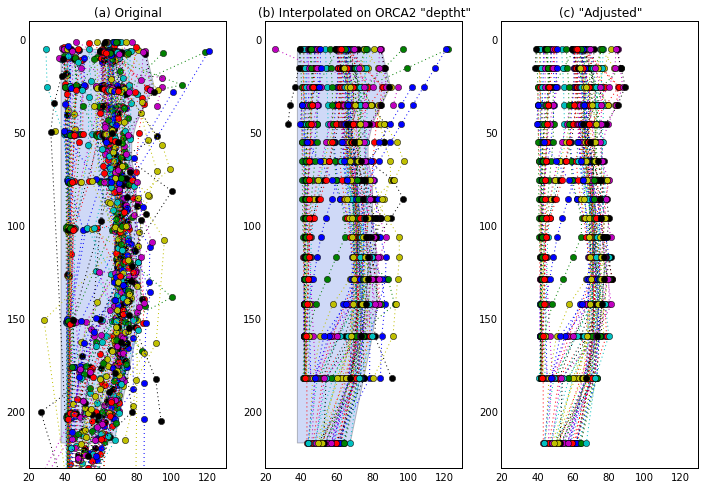

In [16]:
fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

AX = [ax1, ax2, ax3]
for i in range(3):
    AX[i].set_ylim(-10, 230); AX[i].set_xlim(20, 130); AX[i].invert_yaxis()
    AX[i].xaxis.set_tick_params(size=0)
    AX[i].yaxis.set_tick_params(size=0)
    
#for i in range(len(GIPY_locs)):
#    ax1.plot(GIPY_Ba[GIPY_lons==GIPY_locs[i]], GIPY_deps[GIPY_lons==GIPY_locs[i]], 'kx:', ms=6, mew=2.5, label='GIPY  2007-11 obs.')
#for i in range(len(loc03)):
#    ax1.plot(Ba03[x03 == loc03[i]], z03[x03 == loc03[i]], 'k^:', ms=6, mew=0.5, label='BGEP 2003-21 obs.')
#for i in range(len(loc04)):
#    ax1.plot(Ba04[x04 == loc04[i]], z04[x04 == loc04[i]], 'k+:', ms=8, mew=2.5, label='BGEP 2004-16 obs.')
#for i in range(len(loc05)):
#    ax1.plot(Ba05[x05 == loc05[i]], z05[x05 == loc05[i]], 'k*:', ms=8, mew=1.0, label='BGEP 2005-04 obs.')
for i in range(len(locx)):
    ax1.plot(Ba_all[x_all==locx[i]], z_all[x_all==locx[i]], 'o:')
ax1.fill_betweenx(dep_surf, bounds_low, bounds_up,  facecolor=RB, alpha=0.25)
ax1.set_title('(a) Original', fontsize=12)


ax2.plot(out_surf.T, dep_surf, 'o:')
ax2.fill_betweenx(dep_surf, bounds_low, bounds_up,  facecolor=RB, alpha=0.25)
ax2.set_title('(b) Interpolated on ORCA2 "deptht"')

ax3.plot(out_adj.T, dep_surf, 'o:')
ax3.set_title('(c) "Adjusted"')

### Above 500m

In [17]:
x_surf = x_all[z_all<500]; y_surf = y_all[z_all<500]; z_surf = z_all[z_all<500]
Ba_surf = Ba_all[z_all<500]; dep_surf = deptht[deptht<500]

In [18]:
locx, locy, out_surf = int_profile(x_surf, y_surf, z_surf, Ba_surf, dep_surf, thres=2)

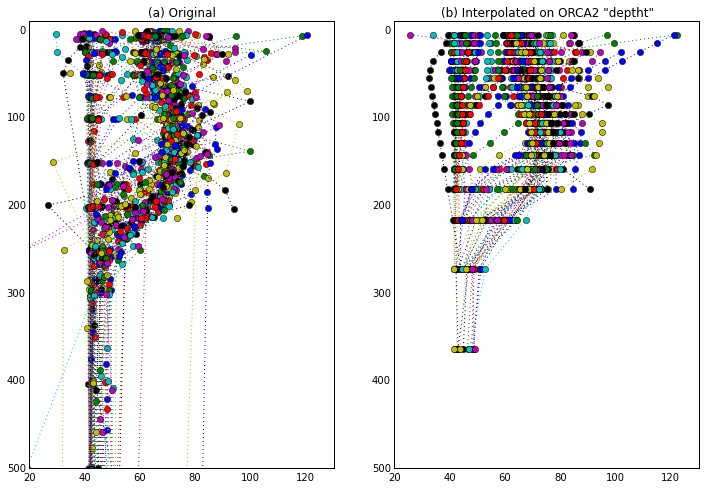

In [19]:
fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

AX = [ax1, ax2]
for i in range(2):
    AX[i].set_ylim(-10, 500); AX[i].set_xlim(20, 130); AX[i].invert_yaxis()
    AX[i].xaxis.set_tick_params(size=0)
    AX[i].yaxis.set_tick_params(size=0)

for i in range(len(locx)):
    ax1.plot(Ba_all[x_all==locx[i]], z_all[x_all==locx[i]], 'o:')
ax1.set_title('(a) Original', fontsize=12)

ax2.plot(out_surf.T, dep_surf, 'o:')
ax2.set_title('(b) Interpolated on ORCA2 "deptht"')

### Deep ocean

In [20]:
z_deep = z_all[z_all>=500]; Ba_deep = Ba_all[z_all>=500]; dep_deep = deptht[deptht>=500]

In [21]:
out_deep, bcount = bin_profile(z_deep, Ba_deep, dep_deep)

In [22]:
bcount

array([ 10.,  47.,   6.,  27.,  34.,  27.,  37.,  15.,  11.,   3.,   0.,
        46.])

In [23]:
out_deep[10] = (out_deep[9]+out_deep[11])/2

In [24]:
num = np.size(out_surf, 0)
out_deep_bdcasted = np.ones([num, len(out_deep)])
for i in range(len(out_deep)):
    out_deep_bdcasted[:, i] = out_deep_bdcasted[:, i]*out_deep[i]

### Combined

In [25]:
Ba_all_int = np.hstack((out_surf, out_deep_bdcasted))

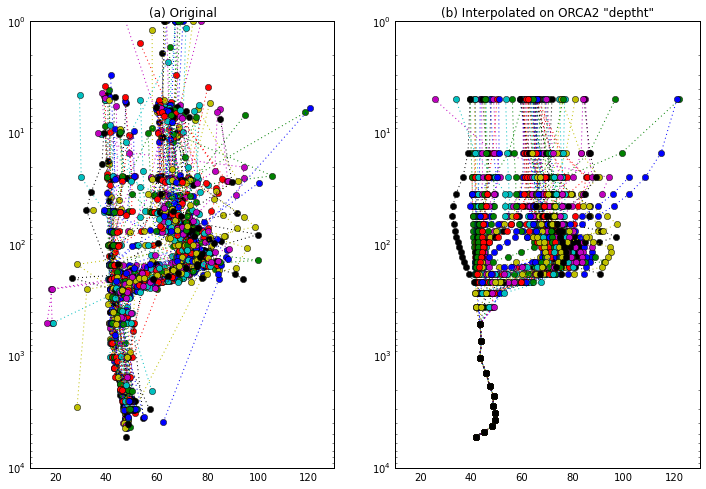

In [26]:
fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

AX = [ax1, ax2]
for i in range(2):
    AX[i].set_ylim(1, 10000); AX[i].set_xlim(10, 130)
    AX[i].xaxis.set_tick_params(size=0)
    AX[i].yaxis.set_tick_params(size=0)
    AX[i].set_yscale('log')
    AX[i].invert_yaxis()

for i in range(len(locx)):
    ax1.plot(Ba_all[x_all==locx[i]], z_all[x_all==locx[i]], 'o:')
ax1.set_title('(a) Original', fontsize=12)

ax2.plot(Ba_all_int.T, deptht, 'o:')
ax2.set_title('(b) Interpolated on ORCA2 "deptht"')

## Horizontal frame

### Projection transformation

<img src="_figures/Projxy.PNG" width=450 align="left"/>

*The reference surface with geographic coordinates $\mathsf{(\phi,\lambda)}$ is projected onto a 2D Cartesian plane $\mathsf{(x, y)}$.*

In [28]:
#p1 = pyproj.Proj('+proj=stere')
p1=Basemap(projection='npstere', resolution='l', boundinglat=0, lon_0=90)
# reproj x, y
x_trans, y_trans = p1(locx, locy)
# create frame
listx_trans = np.linspace(1.1e7, 1.5e7, 100)
listy_trans = np.linspace(1.1e7, 1.5e7, 100)
gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)
# convert frame back to lat/lon
listx, listy = p1(listx_trans, listy_trans, inverse=True)
gridx, gridy = p1(gridx_trans, gridy_trans, inverse=True)

### Interpolating each layer

data points participated: 84
data points participated: 86
data points participated: 93
data points participated: 93
data points participated: 94
data points participated: 94
data points participated: 94
data points participated: 94


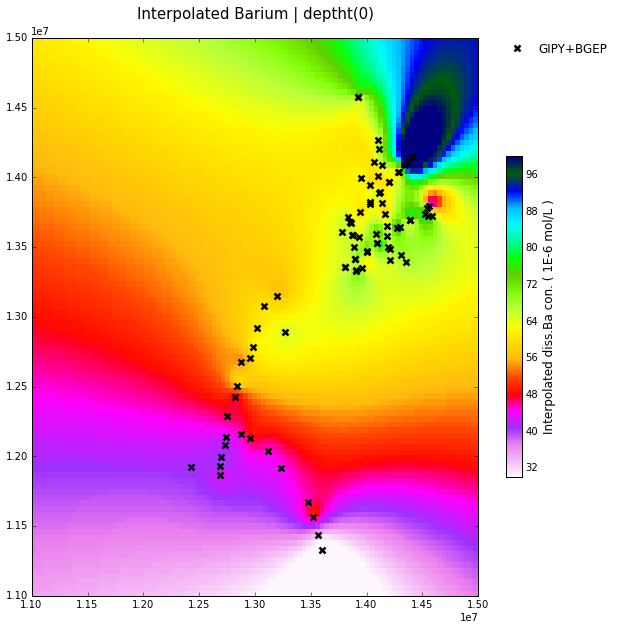

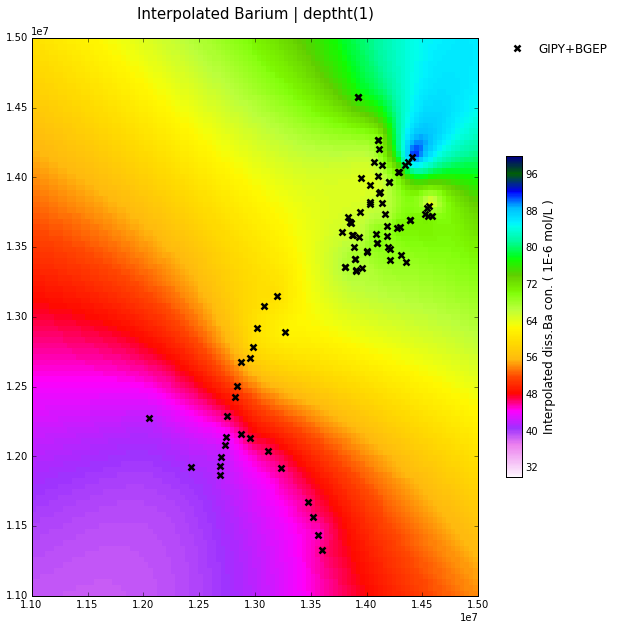

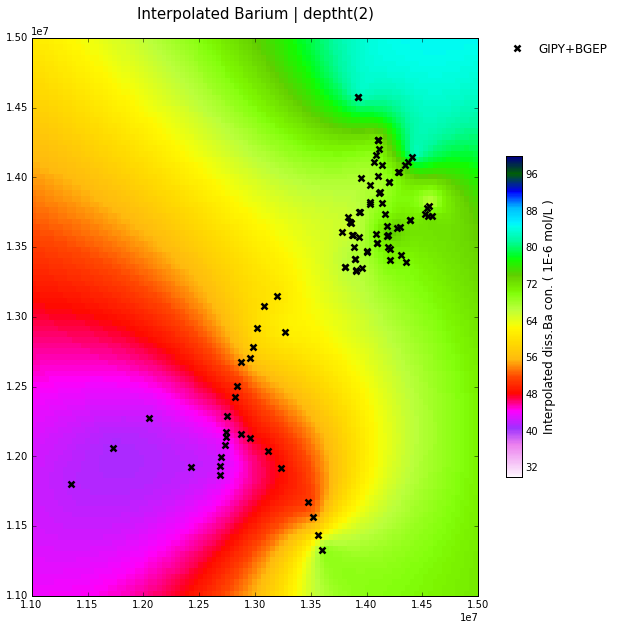

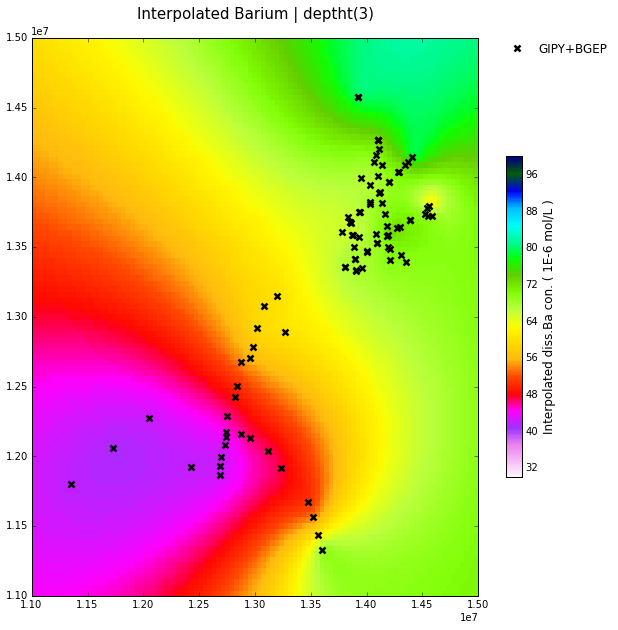

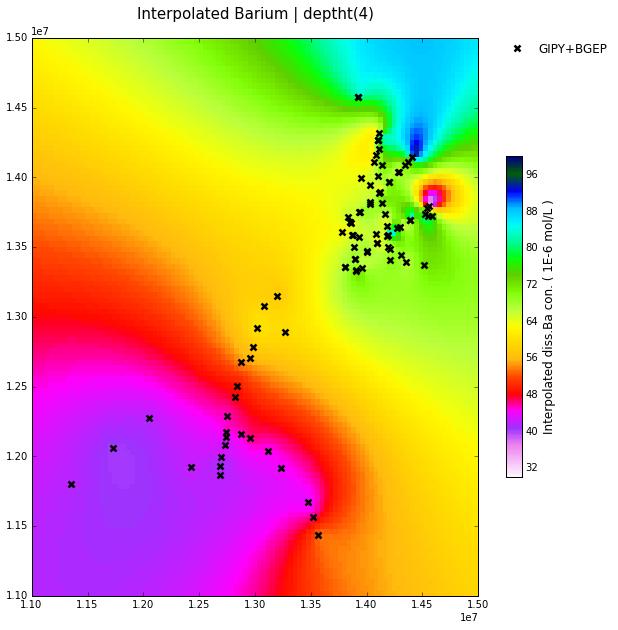

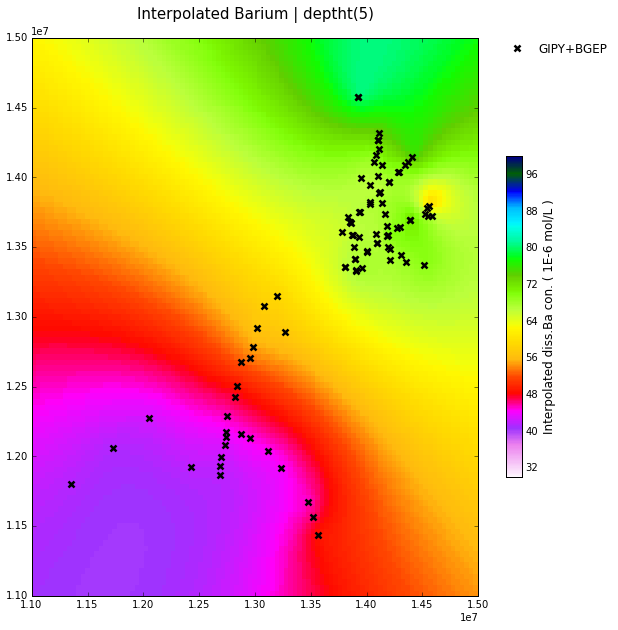

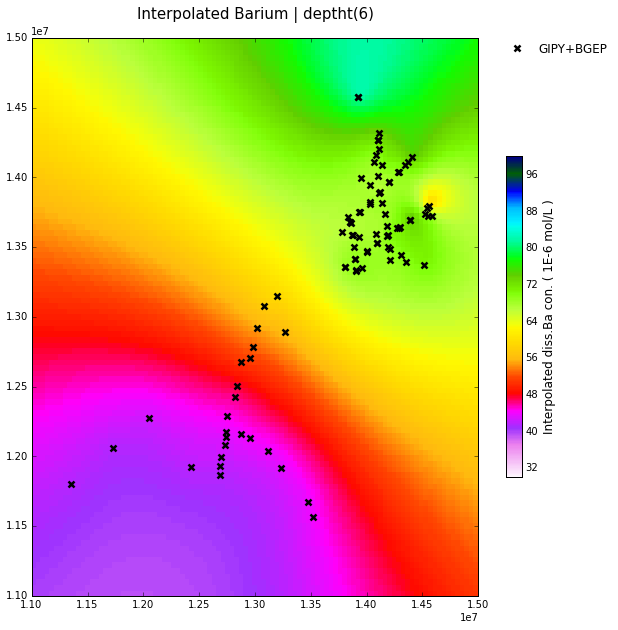

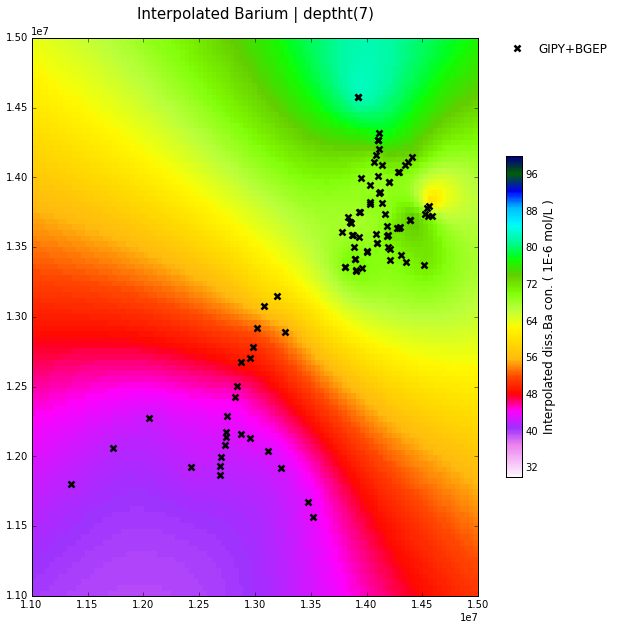

In [29]:
for i in range(8):
    
    Ba_layer = Ba_all_int[:, i]
    Ba_temp = Ba_layer[~np.isnan(Ba_layer)]
    x_temp = x_trans[~np.isnan(Ba_layer)]
    y_temp = y_trans[~np.isnan(Ba_layer)]
    print('data points participated: {}'.format(len(Ba_temp)))
    
    OK = OrdinaryKriging(x_temp, y_temp, Ba_temp, variogram_model='linear', verbose=False, enable_plotting=False)
    Ba_int, ss = OK.execute('grid', listx_trans, listy_trans)
    
    fig=plt.figure(figsize=(10, 10))
    ax=fig.gca()
    ax.set_xlim(1.1e7, 1.5e7)
    ax.set_ylim(1.1e7, 1.5e7)
    CS = ax.pcolor(gridx_trans, gridy_trans, Ba_int, vmin=30, vmax=100, cmap=plt.cm.gist_ncar_r)
    
    ax.plot(x_temp, y_temp, 'kx', ms=6, mew=2.5, label='GIPY+BGEP')
    
    CBar = plt.colorbar(CS, shrink=0.575)
    CBar.set_label('Interpolated diss.Ba con. ( 1E-6 mol/L )', fontsize=12)
    CBar.ax.tick_params(axis='y', length=0)
    LG = ax.legend(numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
    ax.set_title('Interpolated Barium | deptht('+str(i)+')', fontsize=15, y=1.025)
    
    #fig.savefig('Publish/Barium_layer_'+str(i)+'modified.pdf', dpi=400, orientation='portrait', papertype='a4', format='pdf',
    #        transparent=False, bbox_inches='tight', pad_inches=0)

### A comparison: directly interpolating each layers

do as:
```python    
deptht[i]< CTD_dep <= deptht[i+1]
```

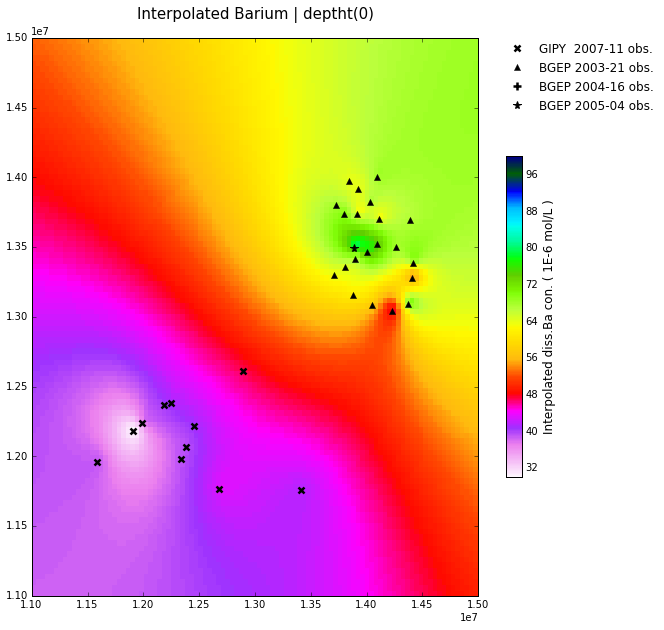

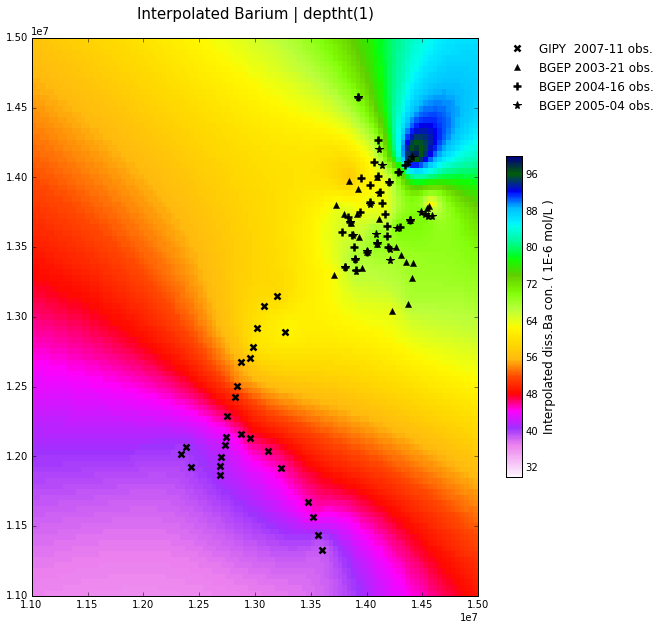

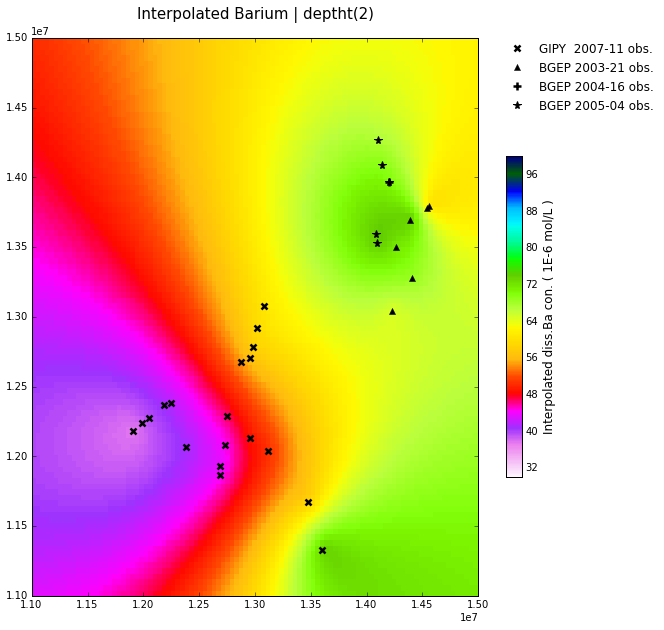

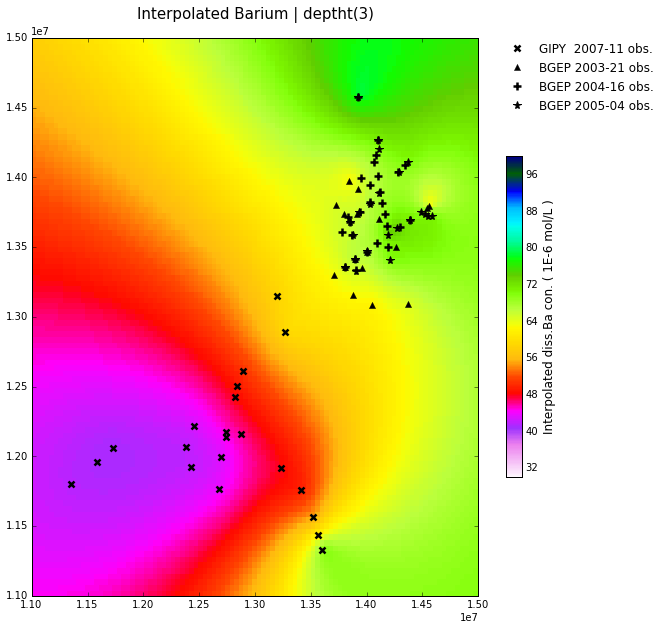

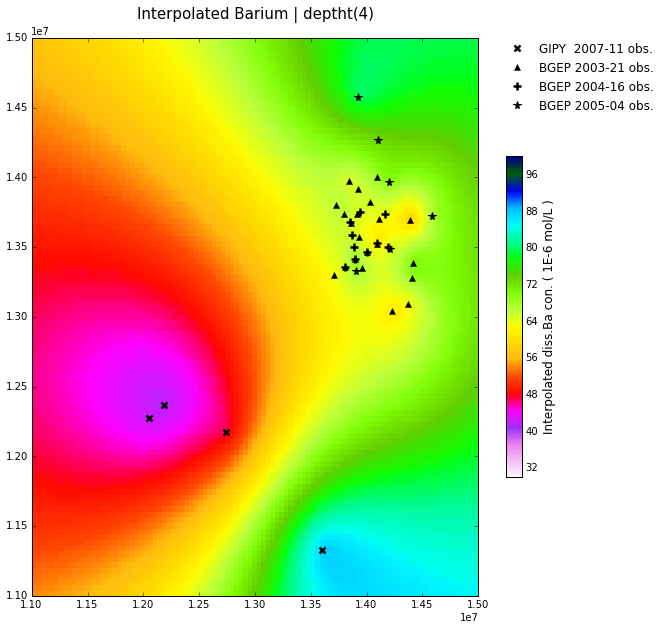

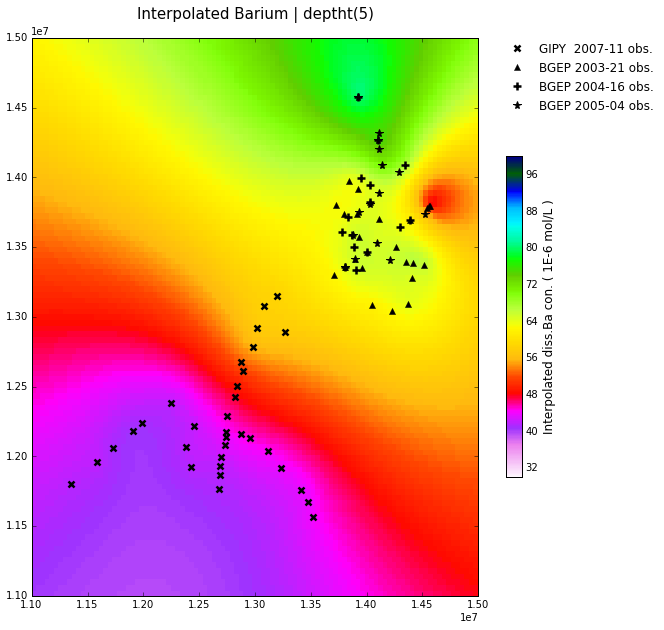

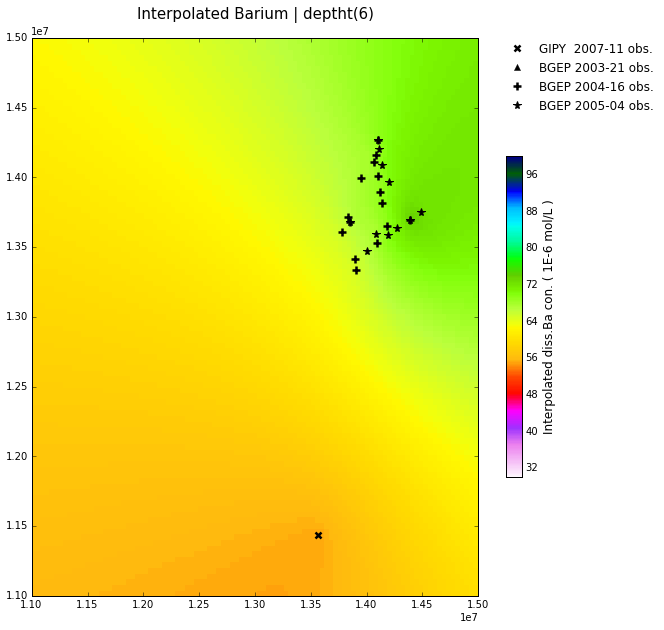

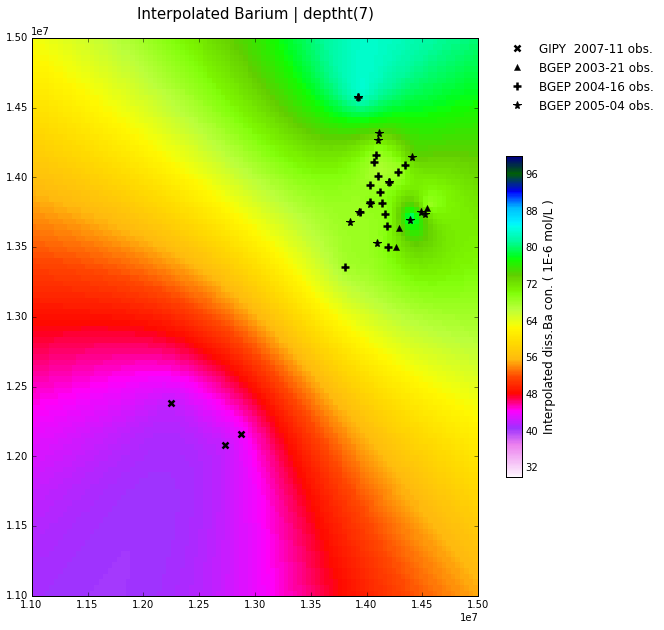

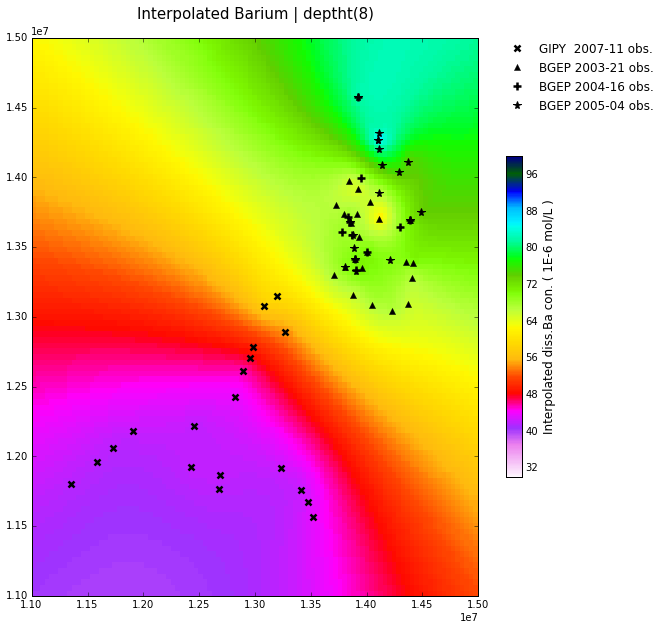

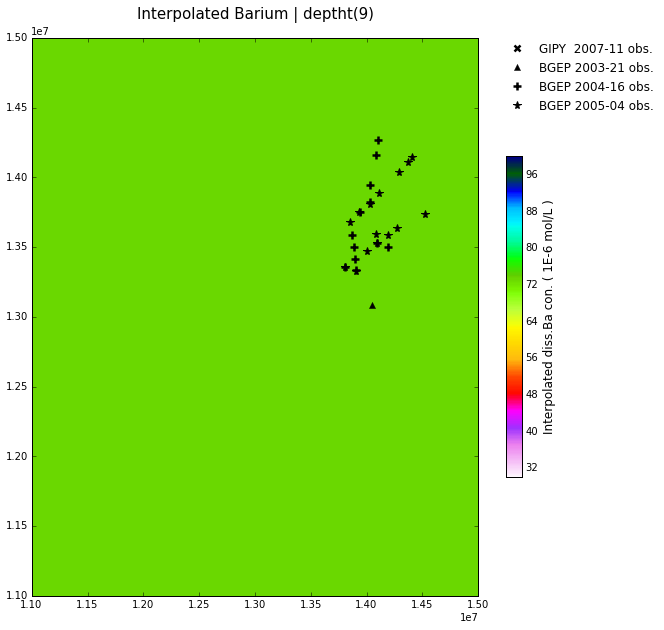

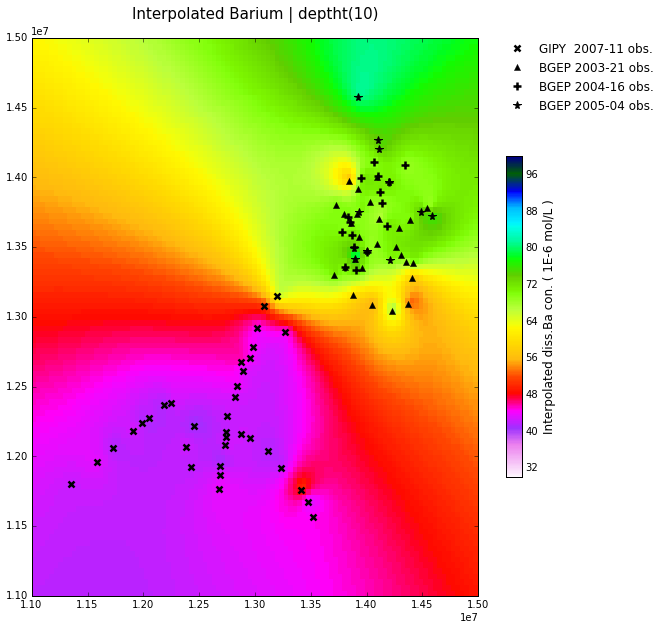

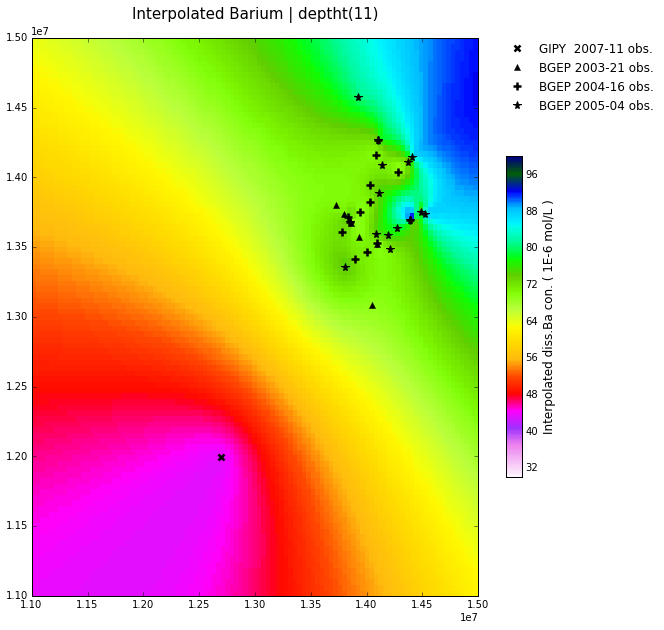

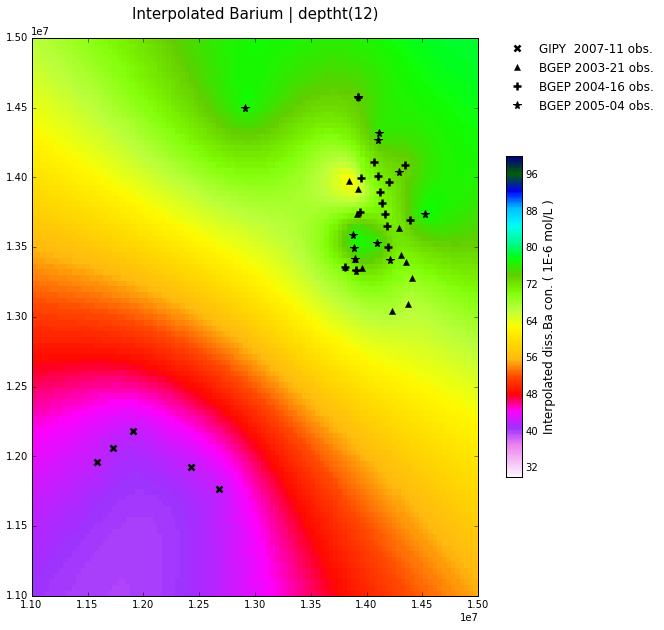

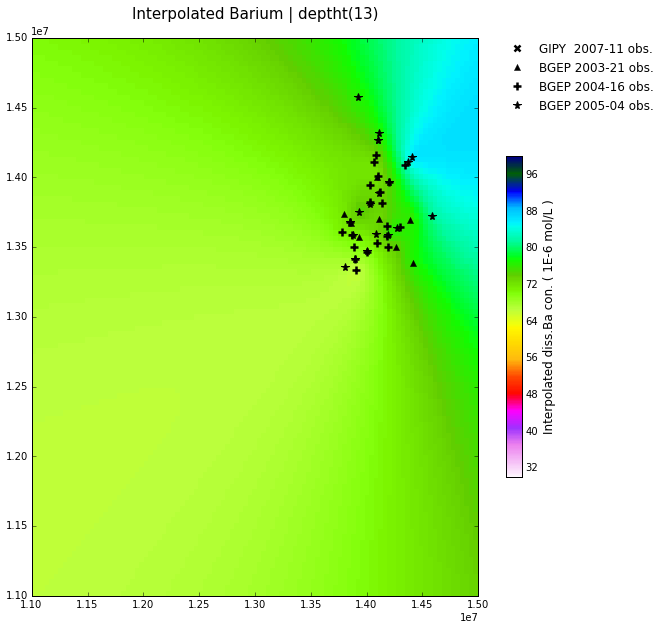

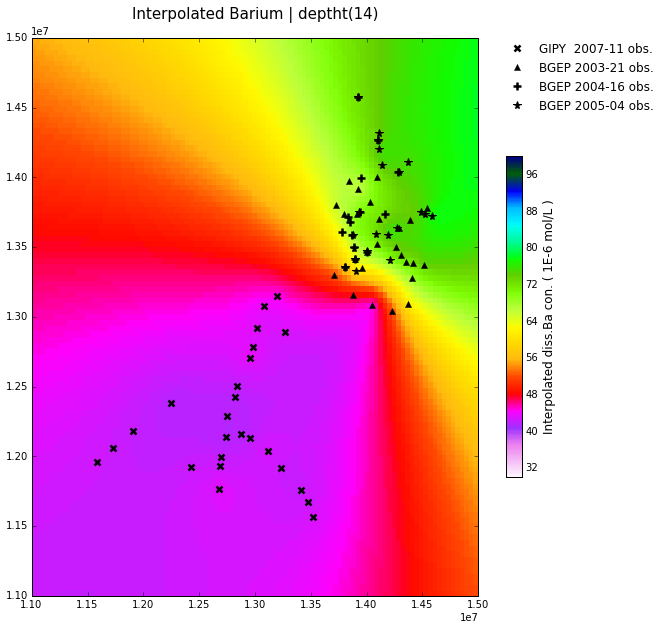

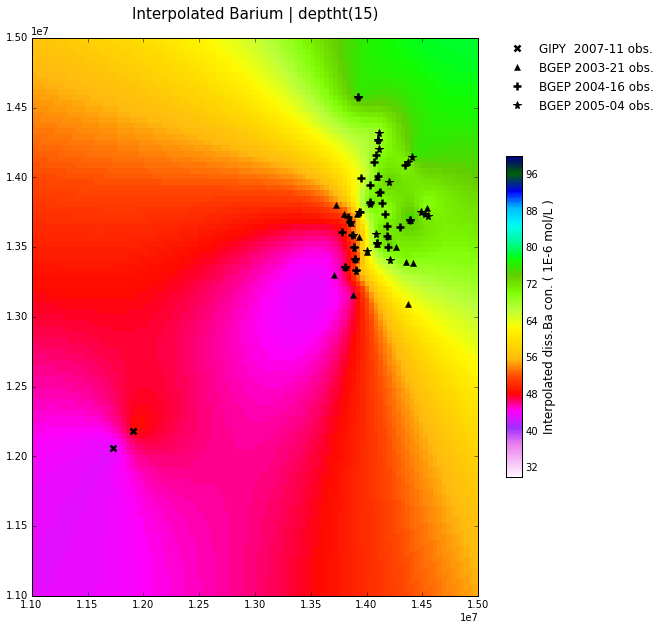

In [51]:
for i in range(16):
    
    MAT = scipy.io.loadmat('_data/Samples/GIPY11/GIPY11_Ba.mat')
    GIPY_lons = MAT['Ba_records'][:, 0]
    GIPY_lats = MAT['Ba_records'][:, 1]
    GIPY_deps = MAT['Ba_records'][:, 2]
    GIPY_Ba   = MAT['Ba_records'][:, 3]
    
    MAT = scipy.io.loadmat('_data/Samples/BGEP/BGEP_Ba.mat')
    x03 = MAT['Ba2003'][:, 1]; y03 = MAT['Ba2003'][:, 0]; z03 = MAT['Ba2003'][:, 2]; Ba03 = MAT['Ba2003'][:, 3]
    x04 = MAT['Ba2004'][:, 1]; y04 = MAT['Ba2004'][:, 0]; z04 = MAT['Ba2004'][:, 2]; Ba04 = MAT['Ba2004'][:, 3]
    x04[Ba04<0]=np.nan; y04[Ba04<0]=np.nan; z04[Ba04<0]=np.nan; Ba04[Ba04<0]=np.nan
    x05 = MAT['Ba2005'][:, 1]; y05 = MAT['Ba2005'][:, 0]; z05 = MAT['Ba2005'][:, 2]; Ba05 = MAT['Ba2005'][:, 3]
    
    dep = np.hstack((0, dep_int))
    
    hit = ((GIPY_deps >= dep[i])&(GIPY_deps < dep[i+1]))
    lon_surf = GIPY_lons[hit]; lat_surf = GIPY_lats[hit]; Ba_surf  = GIPY_Ba[hit]
    _, indices = np.unique(lon_surf, return_index=True)
    GIPY_x = lon_surf[indices]; GIPY_y = lat_surf[indices]; GIPY_Ba = Ba_surf[indices]
    #
    #GIPY_x[GIPY_x>180]=GIPY_x[GIPY_x>180]-360

    hit = ((z03 >= dep[i])&(z03 < dep[i+1]))
    lon_surf = x03[hit]; lat_surf = y03[hit]; Ba_surf  = Ba03[hit]
    _, indices = np.unique(lon_surf, return_index=True)
    BGEP03_x = lon_surf[indices]; BGEP03_y = lat_surf[indices]; BGEP03_Ba = Ba_surf[indices]

    hit = ((z04 >= dep[i])&(z04 < dep[i+1]))
    lon_surf = x04[hit]; lat_surf = y04[hit]; Ba_surf  = Ba04[hit]
    _, indices = np.unique(lon_surf, return_index=True)
    BGEP04_x = lon_surf[indices]; BGEP04_y = lat_surf[indices]; BGEP04_Ba = Ba_surf[indices]

    hit = ((z05 >= dep[i])&(z05 < dep[i+1]))
    lon_surf = x05[hit]; lat_surf = y05[hit]; Ba_surf  = Ba05[hit]
    _, indices = np.unique(lon_surf, return_index=True)
    BGEP05_x = lon_surf[indices]; BGEP05_y = lat_surf[indices]; BGEP05_Ba = Ba_surf[indices]

    x = np.hstack((GIPY_x, BGEP03_x, BGEP04_x, BGEP05_x))
    y = np.hstack((GIPY_y, BGEP03_y, BGEP04_y, BGEP05_y))
    Ba = np.hstack((GIPY_Ba, BGEP03_Ba, BGEP04_Ba, BGEP05_Ba))

    #p1 = pyproj.Proj('+proj=stere')
    p1=Basemap(projection='npstere', resolution='l', boundinglat=0, lon_0=90)
    # reproj x, y
    x_trans, y_trans = p1(x, y)
    # create frame
    listx_trans = np.linspace(1.1e7, 1.5e7, 100)
    listy_trans = np.linspace(1.1e7, 1.5e7, 100)
    gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)
    # convert frame back to lat/lon
    listx, listy = p1(listx_trans, listy_trans, inverse=True)
    gridx, gridy = p1(gridx_trans, gridy_trans, inverse=True)

    GIPYx_trans, GIPYy_trans = p1(GIPY_x, GIPY_y)
    BGEP03x_trans, BGEP03y_trans = p1(BGEP03_x, BGEP03_y)
    BGEP04x_trans, BGEP04y_trans = p1(BGEP04_x, BGEP04_y)
    BGEP05x_trans, BGEP05y_trans = p1(BGEP05_x, BGEP05_y)

    OK = OrdinaryKriging(x_trans, y_trans, Ba, variogram_model='linear', verbose=False, enable_plotting=False)
    Ba_int, ss = OK.execute('grid', listx_trans, listy_trans)

    fig=plt.figure(figsize=(10, 10))
    ax=fig.gca()
    ax.set_xlim(1.1e7, 1.5e7)
    ax.set_ylim(1.1e7, 1.5e7)
    CS = ax.pcolor(gridx_trans, gridy_trans, Ba_int, vmin=30, vmax=100, cmap=plt.cm.gist_ncar_r)
    ax.plot(  GIPYx_trans,  GIPYy_trans, 'kx', ms=6, mew=2.5, label='GIPY  2007-11 obs.')
    ax.plot(BGEP03x_trans, BGEP03y_trans, 'k^', ms=6, mew=0.5, label='BGEP 2003-21 obs.')
    ax.plot(BGEP04x_trans, BGEP04y_trans, 'k+', ms=8, mew=2.5, label='BGEP 2004-16 obs.')
    ax.plot(BGEP05x_trans, BGEP05y_trans, 'k*', ms=8, mew=1.0, label='BGEP 2005-04 obs.')
    CBar = plt.colorbar(CS, shrink=0.575)
    CBar.set_label('Interpolated diss.Ba con. ( 1E-6 mol/L )', fontsize=12)
    CBar.ax.tick_params(axis='y', length=0)
    LG = ax.legend(numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
    ax.set_title('Interpolated Barium | deptht('+str(i)+')', fontsize=15, y=1.025)
    
    fig.savefig('Publish/Barium_layer'+str(i)+'.pdf', dpi=400, orientation='portrait', papertype='a4', format='pdf',
            transparent=False, bbox_inches='tight', pad_inches=0)

In [26]:
## Save
#save_var = { 'Ba_int': Ba_int, 'lon': gridx, 'lat': gridy}#, 'lon_trans':gridx_trans, 'lat_trans':gridy_trans  }
#scipy.io.savemat('_data/Exchange/Temp_Ba_int.mat', mdict=save_var)

# Remap on ORCA2 frame

In [28]:
coordinate_name=glob.glob('_data/NEMO/ORCA2_INPUT/coordinates*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

In [29]:
Ba_ini_orca = Nts.reporj_NEMOgrid(gridx, gridy, Ba_int, nav_lon, nav_lat, method='linear')

In [30]:
hit = find_inland(nav_lon, nav_lat); Ba_ini_orca[hit==1]=np.nan
Ba_ini_masked = np.ma.masked_where(np.isnan(Ba_ini_orca), Ba_ini_orca)

## Plot

In [31]:
ETOPO2_Arctic=scipy.io.loadmat('_libs/ETOPO2_Arctic.mat')
lon_arctic=ETOPO2_Arctic['lon_arctic']
lat_arctic=ETOPO2_Arctic['lat_arctic']
topo_arctic=ETOPO2_Arctic['topo_arctic']

In [32]:
# Adjust resolution
res_unit=5
lon_arctic=lon_arctic[0:-1:res_unit, 0:-1:res_unit]
lat_arctic=lat_arctic[0:-1:res_unit, 0:-1:res_unit]
topo_arctic=topo_arctic[0:-1:res_unit, 0:-1:res_unit]*-1

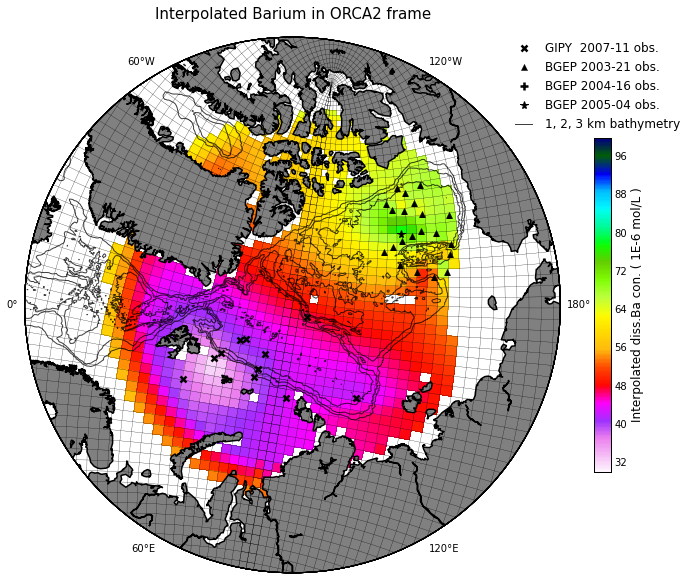

In [34]:
clevs=[1000, 2000, 3000]
fig=plt.figure(figsize=(12, 12)); ax=plt.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
gridx, gridy = proj(nav_lon, nav_lat)
GIPYx_trans, GIPYy_trans = proj(GIPY_x, GIPY_y)
BGEP03x_trans, BGEP03y_trans = proj(BGEP03_x, BGEP03_y)
BGEP04x_trans, BGEP04y_trans = proj(BGEP04_x, BGEP04_y)
BGEP05x_trans, BGEP05y_trans = proj(BGEP05_x, BGEP05_y)
topox, topoy = proj(lon_arctic, lat_arctic)
CS = proj.pcolor(gridx, gridy, Ba_ini_masked, vmin=30, vmax=100, cmap=plt.cm.gist_ncar_r)
CS2 = proj.contour(topox, topoy, topo_arctic, clevs, linestyles='-', linewidths=1, colors=('k',), alpha=0.75)
CS2.collections[0].set_label('1, 2, 3 km bathymetry')
proj.plot(  GIPYx_trans, GIPYy_trans, 'kx', ms=6, mew=2.5, label='GIPY  2007-11 obs.')
proj.plot(BGEP03x_trans, BGEP03y_trans, 'k^', ms=6, mew=0.5, label='BGEP 2003-21 obs.')
proj.plot(BGEP04x_trans, BGEP04y_trans, 'k+', ms=8, mew=2.5, label='BGEP 2004-16 obs.')
proj.plot(BGEP05x_trans, BGEP05y_trans, 'k*', ms=8, mew=1.0, label='BGEP 2005-04 obs.')
proj.plot(gridx.T, gridy.T, 'k-', lw=0.25)
proj.plot(gridx, gridy, 'k-', lw=0.25)
CBar = plt.colorbar(CS, shrink=0.5)
CBar.set_label('Interpolated diss.Ba con. ( 1E-6 mol/L )', fontsize=12)
CBar.ax.tick_params(axis='y', length=0)
LG = ax.legend(numpoints=1, bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
ax.set_title('Interpolated Barium in ORCA2 frame', fontsize=15, y=1.025)
#fig.savefig('Publish/Barium_4.pdf', dpi=600, orientation='portrait', papertype='a4', format='pdf',
#            transparent=False, bbox_inches='tight', pad_inches=0)

**Compare with Guay (1997)'s work'**

<img src="_figures/Gauy_Ba_map.PNG" width=650 align="left"/>